# Bayesian A/B Testing
### Leveraging Bayesian Statistics to Evaluate Test Variants in Mobile Gaming
Developed by *A. C. Sanders* | 2024

## Project Overview

This project demonstrates the power of Bayesian A/B Testing in analyzing player retention for the mobile game *Cookie Cats*. Using this robust statistical framework, we investigate whether a test variant improves player engagement, as measured by the binary metric, *retention_1* — which indicates whether a player returns the day after signing up. The test group is referred to as *gate_40* in the dataset whereas the control group is referred to as *gate_30*.

**Key highlights:**

1. Custom Python Functionality: A flexible function for Bayesian A/B testing that leverages Monte Carlo simulation and non-informative priors. Non-informative priors allow for the data to guide our inference. But the function can be adapted to accommodate informative priors when domain knowledge is available.
2. Posterior Estimation: Monte Carlo techniques derive posterior distributions.
3. Probability that the test variant is better than the control group.
4. A 95% credibility interval for the estimated lift.
5. Conditional Risk Analysis that quantifies the downside risk of adopting the test variant *if the control variant is actually better*.
6. Visualization: intuitive plots for posterior distributions and the difference in lift between test and control groups.
This notebook is an excellent resource for data scientists and analysts who want to explore Bayesian approaches to A/B testing. For details on methodology, dataset, and setup instructions, refer to the **README** in the GitHub repository.

## Import Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

## Import Data
Data available in the Github repo

In [8]:
# save file path
file_path = r"C:\Users\adams\OneDrive\Desktop\cookie_cats.csv"

# load into dataframe
data = pd.read_csv(file_path)

# Display the first few rows
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Quick Summary Statistics and EDA

In [10]:
# first make a copy of our data
df = data.copy()

# df information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [11]:
# number of null per column
nulls_per_column = df.isnull().sum()

print("Number of nulls per column:")
print(nulls_per_column)

Number of nulls per column:
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [12]:
# summary stats - in this case we will sum_gamerounds is our only numeric variable
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


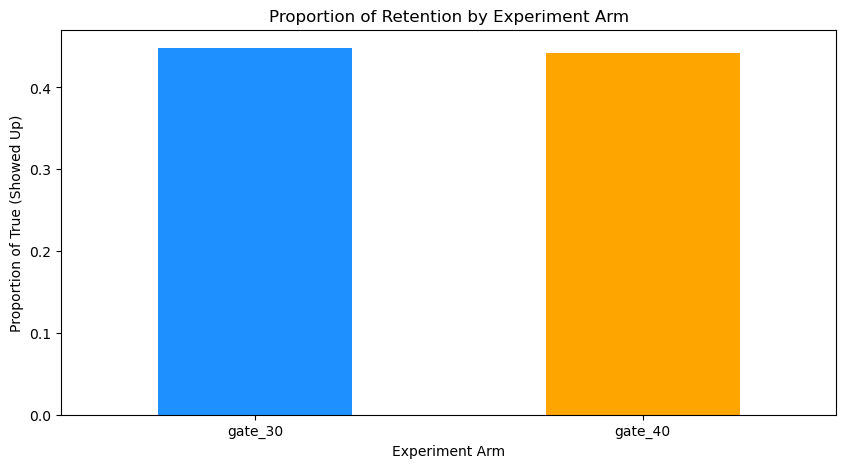

Proportion of True for retention_1 by experiment arm:
version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64


In [13]:
# let's look at the proportion of users that returned the next day (True for retention_d1) broken out by arm (version)

# we can use groupby('version') and aggregate for retention_1
proportion_true = df.groupby('version')['retention_1'].mean()

# colors for the two experiment arms
colors = ['dodgerblue', 'orange']

# proportion plot
proportion_true.plot(
    kind='bar', 
    color=colors,
    figsize=(10, 5), 
    title="Proportion of Retention by Experiment Arm"
)
plt.ylabel("Proportion of True (Showed Up)")
plt.xlabel("Experiment Arm")
plt.xticks(rotation=0)
plt.show()

# display the results
print("Proportion of True for retention_1 by experiment arm:")
print(proportion_true)

## Data Transformation
Rename *gate_30* and *gate_40* values to *control* and *test*, respectively. Afterwards, convert *retention_1* to a binary variable for testing.

In [15]:
# rename gate_30 to control and gate_40 to test using the replace() function
df['version'] = df['version'].replace({'gate_30': 'control', 'gate_40': 'test'})

# check and verify
print(df['version'].value_counts())

version
test       45489
control    44700
Name: count, dtype: int64


In [16]:
# rename the 'version' column to 'experiment_arm'
df.rename(columns={'version': 'experiment_arm'}, inplace=True)

# check and verify
df.columns

Index(['userid', 'experiment_arm', 'sum_gamerounds', 'retention_1',
       'retention_7'],
      dtype='object')

In [17]:
# next, convert the Boolean variable, retention_1, into a binary variable using astype(int)
df['retention_1'] = df['retention_1'].astype(int)

# check and verify
print(df['retention_1'].value_counts())

retention_1
0    50036
1    40153
Name: count, dtype: int64


## Plotting Functions
Used for plotting posteriors and distribution of estimated lift

In [19]:
# posterior distribution plots
def create_posterior_plt_distplot(test_samples, control_samples,
                                  test_samples_mean, test_samples_median,
                                  control_samples_mean, control_samples_median):
    
    plt.figure(figsize=(10, 6))
    
    # Plot the Test and Control posterior distributions
    plt.hist(test_samples, bins=100, alpha=0.5, label='Test', color='hotpink')
    plt.hist(control_samples, bins=100, alpha=0.5, label='Control', color='blueviolet')
    
    # Plot the Test means and medians
    plt.axvline(test_samples_mean, color='hotpink', linestyle='dashed', linewidth=2, label=f'Test Mean: {round((test_samples_mean*100),2)}')
    plt.axvline(test_samples_median, color='red', linestyle='solid', linewidth=2, label=f'Test Median: {round((test_samples_median*100),2)}')
    
    # Plot the Control means and medians
    plt.axvline(control_samples_mean, color='blueviolet', linestyle='dashed', linewidth=2, label=f'Control Mean: {round((control_samples_mean*100),2)}')
    plt.axvline(control_samples_median, color='purple', linestyle='solid', linewidth=2, label=f'Control Median: {round((control_samples_median*100),2)}')
    
    plt.title('Posterior Distributions')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [20]:
# difference distribution
def create_difference_plt_distplot(diff_samples, credible_interval, credible_interval_lower, credible_interval_upper,
                                   diff_samples_median, diff_samples_30, diff_samples_70, n_simulations):
    
    plt.figure(figsize = (10, 6))

    # create the distribution of differences: test - control
    plt.hist(diff_samples, bins = 100, alpha = 0.5, label = 'Differences', color = 'aquamarine')

    # 95% credibility interval lines
    plt.axvline(credible_interval[0], color = 'red', linestyle = 'dashed', linewidth = 2, label = f'95% lower bound: {round((credible_interval_lower*100),2)}')
    plt.axvline(credible_interval[1], color = 'red', linestyle = 'dashed', linewidth = 2, label = f'95% upper bound: {round((credible_interval_upper*100),2)}')
    
    # point estimates for median, 30th percentile, and 70th percentile
    plt.axvline(diff_samples_median, color = 'dodgerblue', linestyle = 'solid', linewidth = 2, label = f'median: {round((diff_samples_median*100),2)}')
    plt.axvline(diff_samples_30, color = 'purple', linestyle = 'dashed', linewidth = 2, label = f'30%: {round((diff_samples_30*100),2)}')
    plt.axvline(diff_samples_70, color = 'purple', linestyle = 'dashed', linewidth = 2, label = f'70%: {round((diff_samples_70*100),2)}')

    # reference line for 0
    plt.axvline(0, color = 'orange', linestyle = 'dotted', linewidth = 2, label = 0)
    
    plt.title(f'Distribution of Relative Lift (Test - Control) in {n_simulations} Simulations')
    plt.xlabel('Differences')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    
    plt.show()

## Running the Bayesian A/B testing

In [22]:
# segment our data into test and control groups
test_data = df[df['experiment_arm'] == 'test']['retention_1']
control_data = df[df['experiment_arm'] == 'control']['retention_1']

# Monte Carlo simulation set to 10,000
n_simulations = 10000

# we simulate posterior distributions using Beta distribution with non-informative uniform priors
test_posterior = beta(1 + sum(test_data), 1 + len(test_data) - sum(test_data))
control_posterior = beta(1 + sum(control_data), 1 + len(control_data) - sum(control_data))

# Monte Carlo sampling for test and control using rvs()
test_samples = test_posterior.rvs(n_simulations)
control_samples = control_posterior.rvs(n_simulations)

# Calculate the probability that test beats control
prob_test_beats_control = np.mean(test_samples > control_samples)

# Caluclate the posterior distribution means
test_samples_mean = test_samples.mean()
control_samples_mean = control_samples.mean()

# Posterior mean delta
posterior_mean_delta = test_samples_mean - control_samples_mean

# Caluclate the posterior distribution medians
test_samples_median = np.percentile(test_samples, 50)
control_samples_median = np.percentile(control_samples, 50)

# Calculate the relative increase - i.e., the difference
diff_samples = test_samples - control_samples

# Calculate the 95% Credibility Interval
credible_interval = np.percentile(diff_samples, [2.5, 97.5])
credible_interval_lower = credible_interval[0]
credible_interval_upper = credible_interval[1]

# Calculate point estimates: mean, median, 30th percentile, and 70th percentile
diff_samples_mean = diff_samples.mean()
diff_samples_median = np.percentile(diff_samples, 50)
diff_samples_30 = np.percentile(diff_samples, 30)
diff_samples_70 = np.percentile(diff_samples, 70)

# Calculate the expected loss or conditional risk: the average negative differences
conditional_risk = np.mean(diff_samples[diff_samples < 0])

# display results
print(f'test sample posterior mean: {round((test_samples_mean*100),3)}')
print(f'control sample posterior mean: {round((control_samples_mean*100),3)}')
print(f'posterior mean delta: {round((posterior_mean_delta*100),3)}')
print(f'probability that test beats control in {n_simulations} simulations is: {round((prob_test_beats_control*100),2)}')
print(f'95% Credibility Interval: [{round((credible_interval_lower*100),3)}, {round((credible_interval_upper*100),3)}]')
print(f'most likely lift at 50th percentile: {round((diff_samples_median*100),3)}')
print(f'suboptimal lift at 30th percentile: {round((diff_samples_30*100),3)}')
print(f'best case scenario lift around 70th percentile: {round((diff_samples_70*100),3)}')
print(f'conditional risk is: {round((conditional_risk*100),3)}')

test sample posterior mean: 44.226
control sample posterior mean: 44.815
posterior mean delta: -0.59
probability that test beats control in 10000 simulations is: 3.79
95% Credibility Interval: [-1.245, 0.066]
most likely lift at 50th percentile: -0.592
suboptimal lift at 30th percentile: -0.76
best case scenario lift around 70th percentile: -0.418
conditional risk is: -0.618


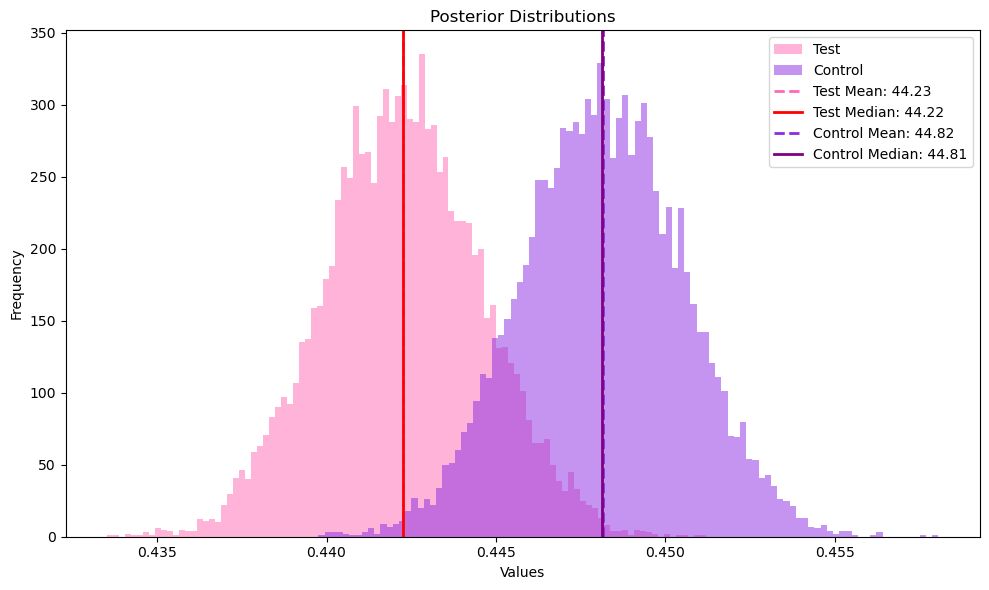

In [23]:
# run the plotting functions
create_posterior_plt_distplot(test_samples, control_samples, test_samples_mean, test_samples_median, control_samples_mean, control_samples_median)

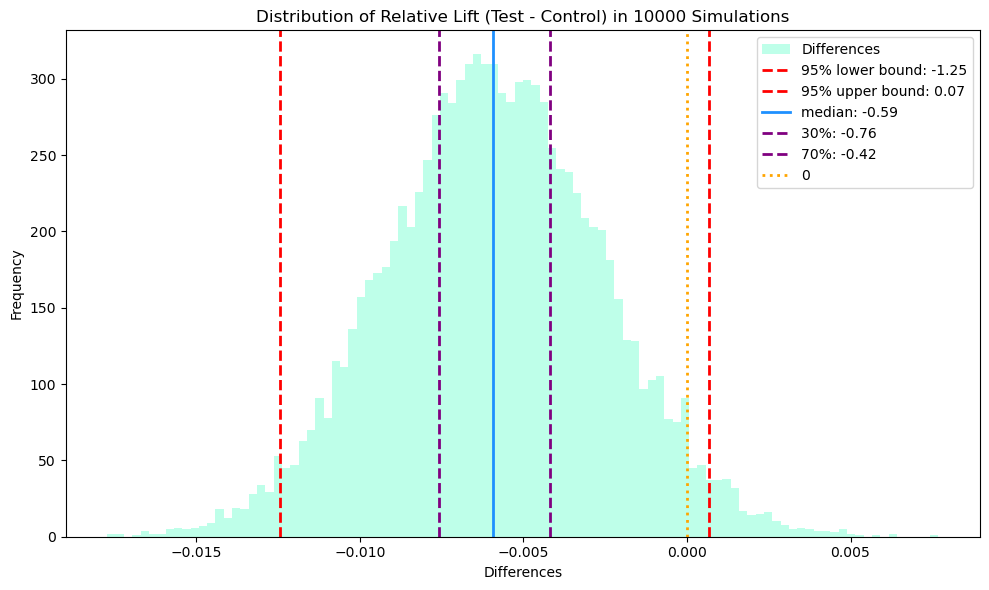

In [24]:
# distribution of estimated lift (test - control) for the simulations
create_difference_plt_distplot(diff_samples, credible_interval, credible_interval_lower, credible_interval_upper, diff_samples_median, diff_samples_30, diff_samples_70, n_simulations)

### Results:
- We can be highly confident that the control variant outperforms the test variant. The test arm has a very low probability that it is better (approximately 4%), whereas the control arm has around a 96% probability that it is better.
- The 95% credibility interval is -1.2% to 0.1%, and the most likely delta (test - control) is -0.6, indicated by the 50th percentile.
- The conditional risk metric is -0.6%